In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [3]:
p1_gen = pd.read_csv('https://raw.githubusercontent.com/SunPy-FIS/FIS-project/main/NEW_Plant_1_Generation_Data.csv')
p2_gen = pd.read_csv('https://raw.githubusercontent.com/SunPy-FIS/FIS-project/main/NEW_Plant_2_Generation_Data.csv')
p1_wea = pd.read_csv('https://raw.githubusercontent.com/SunPy-FIS/FIS-project/main/NEW_Plant_1_Weather_Sensor_Data.csv')
p2_wea = pd.read_csv('https://raw.githubusercontent.com/SunPy-FIS/FIS-project/main/NEW_Plant_2_Weather_Sensor_Data.csv')

# Forecast

### Time series analysis

In [106]:
def ts_daily_yield(data):
    '''Select the DATE_TIME and DAILY_YIELD columns with which we will estimate the model.
    
    Args:
        data (pd.DataFrame)
        
    Returns:
        pd.DataFrame
    '''
    index = pd.to_datetime(data.groupby('DATE_TIME').sum().index.values)
    daily_sum = np.array(data.groupby('DATE_TIME').sum().DAILY_YIELD)
    series = pd.DataFrame()
    series['DATE_TIME'] = index
    series['DAILY_YIELD'] = daily_sum
    series.set_index('DATE_TIME', inplace = True)
    return series

ts_1 = ts_daily_yield(p1_gen)
ts_2 = ts_daily_yield(p2_gen)

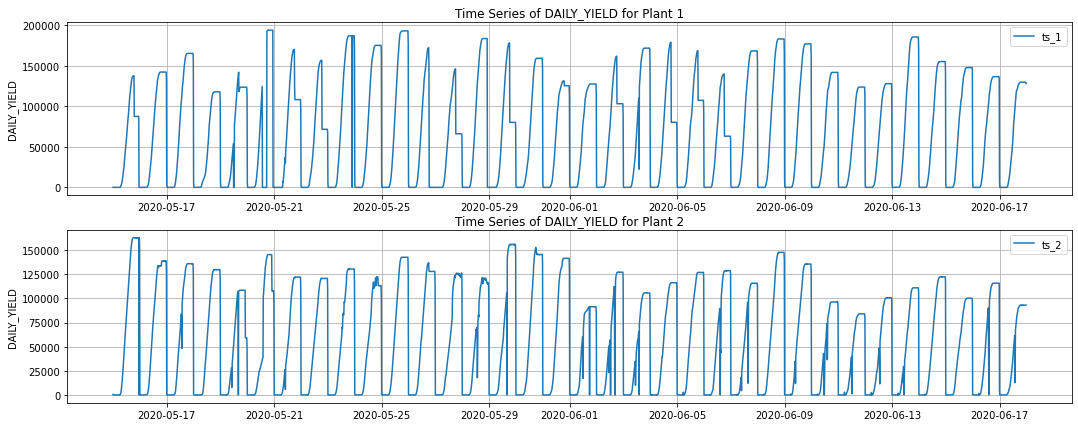

In [148]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (18,7))
axes[0].plot(ts_1, label = 'ts_1')
axes[0].grid()
axes[0].set_title('Time Series of DAILY_YIELD for Plant 1')
axes[0].set_ylabel('DAILY_YIELD')
axes[0].legend()
axes[1].plot(ts_2, label = 'ts_2')
axes[1].grid()
axes[1].set_title('Time Series of DAILY_YIELD for Plant 2')
axes[1].set_ylabel('DAILY_YIELD')
axes[1].legend()
plt.show()

##### Statistical test on time series

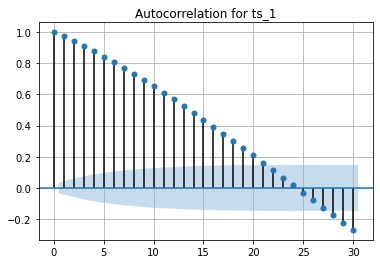

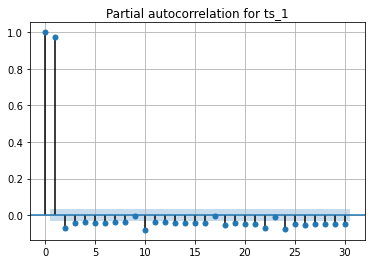

In [133]:
plot_acf(ts_1, lags = 30, alpha = 0.05, title = 'Autocorrelation for ts_1')
plt.grid()
plot_pacf(ts_1, lags = 30, alpha = 0.05, title = 'Partial autocorrelation for ts_1')
plt.grid()

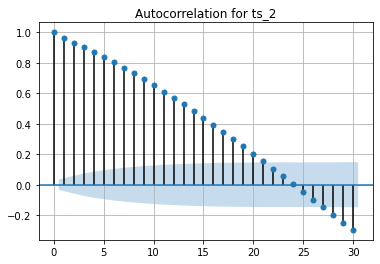

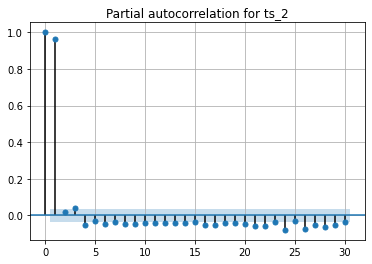

In [134]:
plot_acf(ts_2, lags = 30, alpha = 0.05, title = 'Autocorrelation for ts_2')
plt.grid()
plot_pacf(ts_2, lags = 30, alpha = 0.05, title = 'Partial autocorrelation for ts_2')
plt.grid()

As we can see, given that both the autocorrelation are significant since the first lags and given the general trend of both the autocorrelation functions and partial autocorrelation functions, we can say that the time series has a structure to be modeled. 
To confirm that we are dealing with autocorrelated time series we will use the Durbin-Watson test.

In [110]:
DW_test_1 = durbin_watson(ts_1)
print('Durbin-Watson test for ts_1: {}\n'.format(DW_test_1[0]))
DW_test_2 = durbin_watson(ts_2)
print('Durbin-Watson test for ts_2: {}'.format(DW_test_2[0]))

Durbin-Watson test for ts_1: 0.025667925356789703

Durbin-Watson test for ts_2: 0.03285494505679538


Given that the closer to 0 the statistic is, the more evidence for positive serial correlation, we cannot reject the hyphothesis of no autocorrelation. We can conclude that both time series are autocorrelated. <br>
Now we need to investigate whether the time series is stationary or not. To do this we will use the Dickey-Fuller statistics.

In [111]:
stat_1 = adfuller(ts_1)
print('''ts_1 
    T val: {}    
    p-value: {}\n'''.format(stat_1[0], stat_1[1]))

stat_2 = adfuller(ts_2)
print('''ts_2 
    T val: {}    
    p-value: {}'''.format(stat_2[0], stat_2[1]))

ts_1 
    T val: -14.486240197641736    
    p-value: 6.254316163677751e-27

ts_2 
    T val: -15.156647583042398    
    p-value: 6.6800103148699655e-28


Given the p-value obtained in the two tests we can reject the hypothesis H0, therefore we conclude that both time series are stationary.

### Model and forecast

##### Train/Test split

Since model estimation is very time consuming, we extract a subsample of the dataset, the last 7 days, which we will use for estimating and forecasting.

In [150]:
def last_7_days(ts):
    '''Select the last 7 days from the original time series and then it split this new time series in a new training 
       series, composed by the first 6 days, and testing series, composed by the last day.
    
    Args:
        ts (pd.DataFrame)
        
    Returns:
        splitted_series (tuple): A tuple containing the 7-day time series, the time series for training and the 
        time series for testing, respectively.
    '''
    sub_series = ts[-672:]
    train_series = sub_series[:577]
    test_series = sub_series[576:]
    splitted_series = (sub_series, train_series, test_series) 
    return splitted_series

ts_1_last7 = last_7_days(ts_1)
ts_2_last7 = last_7_days(ts_2)

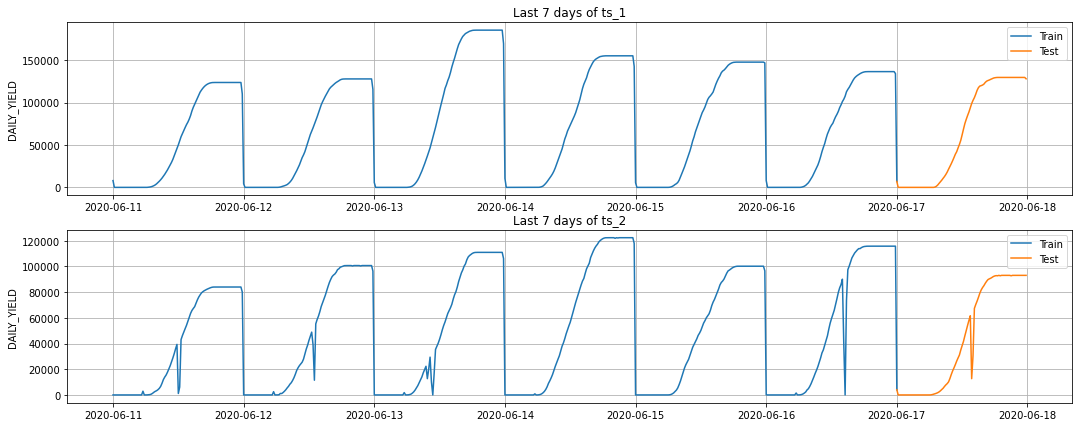

In [151]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (18,7))
axes[0].plot(ts_1_last7[1], label = 'Train')
axes[0].plot(ts_1_last7[2], label = 'Test')
axes[0].set_title('Last 7 days of ts_1')
axes[0].set_ylabel('DAILY_YIELD')
axes[0].legend()
axes[0].grid()
axes[1].plot(ts_2_last7[1], label = 'Train')
axes[1].plot(ts_2_last7[2], label = 'Test')
axes[1].set_title('Last 7 days of ts_2')
axes[1].set_ylabel('DAILY_YIELD')
axes[1].legend()
axes[1].grid()

##### Model fitting

In [153]:
model_1 = ARIMA(ts_1_last7[1], order = (4,1,0), seasonal_order = (0,1,1,96))
model_1_fit = model_1.fit()
model_2 = ARIMA(ts_2_last7[1], order = (4,1,0), seasonal_order = (0,1,1,96))
model_2_fit = model_2.fit()

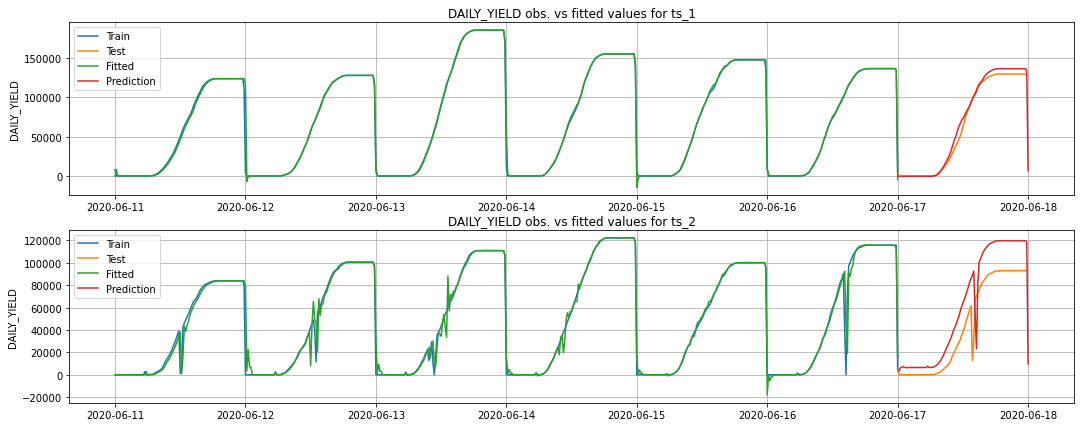

In [160]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (18,7))
axes[0].plot(ts_1_last7[1], label = 'Train')
axes[0].plot(ts_1_last7[2], label = 'Test')
axes[0].plot(model_1_fit.fittedvalues, label = 'Fitted')
axes[0].plot(model_1_fit.forecast(96), label = 'Prediction')
axes[0].set_title('DAILY_YIELD obs. vs fitted values for ts_1')
axes[0].set_ylabel('DAILY_YIELD')
axes[0].legend()
axes[0].grid()
axes[1].plot(ts_2_last7[1], label = 'Train')
axes[1].plot(ts_2_last7[2], label = 'Test')
axes[1].plot(model_2_fit.fittedvalues, label = 'Fitted')
axes[1].plot(model_2_fit.forecast(96), label = 'Prediction')
axes[1].set_title('DAILY_YIELD obs. vs fitted values for ts_2')
axes[1].set_ylabel('DAILY_YIELD')
axes[1].legend()
axes[1].grid()

##### Prediction for 2020-06-18

In [164]:
model_1_tomorrow = ARIMA(ts_1_last7[0], order = (4,1,0), seasonal_order = (0,1,1,96))
model_1_tomorrow_fit = model_1_tomorrow.fit()
model_2_tomorrow = ARIMA(ts_1_last7[0], order = (4,1,0), seasonal_order = (0,1,1,96))
model_2_tomorrow_fit = model_2_tomorrow.fit()

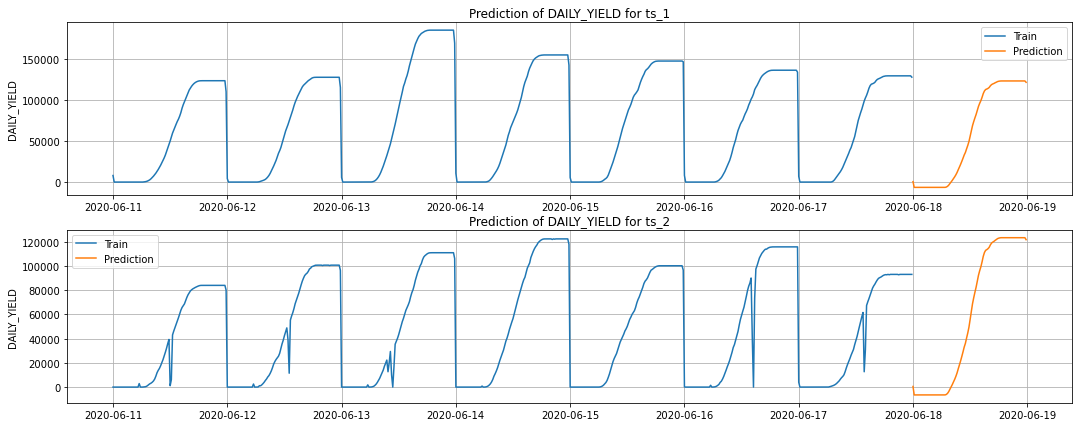

In [167]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (18,7))
axes[0].plot(ts_1_last7[0], label = 'Train')
axes[0].plot(model_1_tomorrow_fit.forecast(96), label = 'Prediction')
axes[0].set_title('Prediction of DAILY_YIELD for ts_1')
axes[0].set_ylabel('DAILY_YIELD')
axes[0].legend()
axes[0].grid()
axes[1].plot(ts_2_last7[0], label = 'Train')
axes[1].plot(model_2_tomorrow_fit.forecast(96), label = 'Prediction')
axes[1].set_title('Prediction of DAILY_YIELD for ts_2')
axes[1].set_ylabel('DAILY_YIELD')
axes[1].legend()
axes[1].grid()